In [1]:
import torch
import time
from torchtext.datasets import AG_NEWS
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch import nn
from torchsummary import summary

train_iter = iter(AG_NEWS(split="train"))

c:\Users\manmu\anaconda3\envs\aio\lib\site-packages\torchtext\datasets\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
c:\Users\manmu\anaconda3\envs\aio\lib\site-packages\torchtext\data\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
c:\Users\manmu\anaconda3\envs\aio\lib\site-packages\torchtext\vocab\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABO

In [2]:
next(train_iter)

(3,
 "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")

## Prepare data processing pipelines

In [3]:
tokenizer = get_tokenizer("basic_english")
train_iter = AG_NEWS(split="train")

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)


vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1
label_pipeline

<function __main__.<lambda>(x)>

In [4]:
vocab(['here', 'is', 'an', 'example'])

[475, 21, 30, 5297]

## Generate data batch and iterator

In [5]:
BATCH_SIZE = 64

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

train_iter, test_iter = AG_NEWS()
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = random_split(
    train_dataset, [num_train, len(train_dataset) - num_train]
)

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

num_class = len(set([label for (label, text) in train_iter]))
vocab_size = len(vocab)

max_lenght = max([len(tokenizer(text)) for (label, text) in train_iter])


In [6]:
print(f'Max lenght: {max_lenght}')
embed_dim = 8

Max lenght: 207


## Define Model 

In [7]:
pe = torch.zeros(max_lenght, embed_dim)
print(pe.shape)
position = torch.arange(0, max_lenght, dtype=torch.float).unsqueeze(1)
print(position.shape)
div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-torch.log(torch.tensor(10000.0)) / embed_dim))
pe[:, 0::2] = torch.sin(position * div_term)
pe[:, 1::2] = torch.cos(position * div_term)
pe = pe.unsqueeze(0).transpose(0, 1)
print(pe.shape)

torch.Size([207, 8])
torch.Size([207, 1])
torch.Size([207, 1, 8])


In [8]:
class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class, hidden_size,num_layers,bidirectional, dropout):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)

        self.lstm = nn.LSTM(embed_dim, hidden_size, num_layers, batch_first=True, 
                            bidirectional=bidirectional, dropout=dropout)
        

        self.fc = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, num_class)  # 4 classes in AG_NEWS

        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)

        output, _ = self.lstm(embedded)
       # output = output[:, -1, :] if not self.lstm.bidirectional else output[:, -1, :].view(text.size(0), -1)
        output = self.fc(output)
        return output

In [9]:
import torch.nn.functional as F

class TextClassificationModelCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class,out_channels,  dropout):
        super(TextClassificationModelCNN, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)

        self.conv1 = nn.Conv1d(in_channels = embed_dim, out_channels=out_channels, kernel_size=3 ,padding=1)
        self.conv2 = nn.Conv1d(in_channels = embed_dim, out_channels=out_channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels = embed_dim, out_channels=out_channels, kernel_size=3, padding=1)
        self.fc = nn.Linear(out_channels*3, num_class)

        self.dropout = nn.Dropout(p=dropout)
        self.init_weights()


    def forward(self, text, offsets):
        embedded = self.embedding(text,offsets)
        embedded = embedded.unsqueeze(2) 
        conv1_out = F.relu(self.conv1(embedded))
        conv2_out = F.relu(self.conv2(embedded))
        conv3_out = F.relu(self.conv3(embedded))
        pooled = torch.cat((conv1_out, conv2_out, conv3_out), dim=1)
        pooled = self.dropout(pooled)
        pooled = F.max_pool1d(pooled, pooled.shape[2]).squeeze(2)
        return self.fc(pooled)

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

In [10]:
print(f'Vocab size: {vocab_size}')
print(f'embed_dim : {embed_dim}')
print(f'num_class: {num_class}')
print(f'max_lenght: {max_lenght}')

Vocab size: 95811
embed_dim : 8
num_class: 4
max_lenght: 207


In [11]:
embed_dim = 512
model = TextClassificationModel(vocab_size, embed_dim, num_class,  hidden_size = 64, num_layers=2, bidirectional=True, dropout=0.1).to(device)
for idx, (label, text, offsets) in enumerate(train_dataloader):
    print(f'Text:  {text.shape}')
    print(f'Offset:  {offsets.shape}')
    output = model(text,offsets)
    break

Text:  torch.Size([2659])
Offset:  torch.Size([64])


In [12]:
embed_dim = 512
model = TextClassificationModelCNN(vocab_size, embed_dim, num_class, out_channels = 256, dropout=0.3).to('cuda')
for idx, (label, text, offsets) in enumerate(train_dataloader):
    print(f'Text:  {text.shape}')
    print(f'Offset:  {offsets.shape}')
    embedded = model.embedding(text,offsets)
    print(embedded.shape)
    embedded = embedded.unsqueeze(2) 
    print(embedded.shape)
    model.conv1(embedded)
    print('-'*10)
    conv1_out = F.relu(model.conv1(embedded))
    conv2_out = F.relu(model.conv2(embedded))
    conv3_out = F.relu(model.conv3(embedded))
    print(conv1_out.shape)
    print(conv2_out.shape)
    print(conv3_out.shape)
    pooled = torch.cat((conv1_out, conv2_out, conv3_out), dim=1)
    print(pooled.shape)
    output = model(text,offsets)
    break

Text:  torch.Size([2659])
Offset:  torch.Size([64])
torch.Size([64, 512])
torch.Size([64, 512, 1])
----------
torch.Size([64, 256, 1])
torch.Size([64, 256, 1])
torch.Size([64, 256, 1])
torch.Size([64, 768, 1])


#### Test Embedding Layer

#### Parameter Counting|

In [13]:
#print(model)
def count_parameters(model):
    total_params = 0
    trainable_params = 0
    for param in model.parameters():
        total_params += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    return total_params, trainable_params

total_params, trainable_params = count_parameters(model)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 50238724
Trainable parameters: 50238724


## Define functions to train the model and evaluate results

In [14]:
EPOCHS = 20  
LR = 0.01 

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_train_acc = [];total_evaluate_acc = []

def train(dataloader):
    model.train()
    total_acc, total_count, total_loss = 0, 0,0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        total_loss += loss.item() * label.size(0)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    return total_acc / total_count, total_loss / total_count

def evaluate(dataloader):
    model.eval()
    total_acc, total_count,total_loss = 0, 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            total_loss += loss.item() * label.size(0)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count , total_loss / total_count

## Split the dataset and run the model

In [15]:
total_accu = None
total_train_acc = [];total_evaluate_acc = []
train_losses=[];val_losses=[]

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    accu_train, train_loss = train(train_dataloader)
    accu_val, val_loss = evaluate(valid_dataloader)
    # Append 
    total_train_acc.append(accu_train); train_losses.append(train_loss)
    total_evaluate_acc.append(accu_val);val_losses.append(val_loss)
    if total_accu is not None and total_accu > accu_val:
        scheduler.step()
    else:
        total_accu = accu_val
    print("-" * 59)
    print(
        "| end of epoch {:3d} | time: {:5.2f}s | "
        "valid accuracy {:8.3f} ".format(
            epoch, time.time() - epoch_start_time, accu_val
        )
    )
    print("-" * 59)

| epoch   1 |   500/ 1782 batches | accuracy    0.865
| epoch   1 |  1000/ 1782 batches | accuracy    0.899
| epoch   1 |  1500/ 1782 batches | accuracy    0.903
-----------------------------------------------------------
| end of epoch   1 | time: 39.60s | valid accuracy    0.915 
-----------------------------------------------------------
| epoch   2 |   500/ 1782 batches | accuracy    0.941
| epoch   2 |  1000/ 1782 batches | accuracy    0.934
| epoch   2 |  1500/ 1782 batches | accuracy    0.931
-----------------------------------------------------------
| end of epoch   2 | time: 40.91s | valid accuracy    0.912 
-----------------------------------------------------------
| epoch   3 |   500/ 1782 batches | accuracy    0.962
| epoch   3 |  1000/ 1782 batches | accuracy    0.966
| epoch   3 |  1500/ 1782 batches | accuracy    0.967
-----------------------------------------------------------
| end of epoch   3 | time: 40.79s | valid accuracy    0.923 
-------------------------------

## Plot Training Process and Evaluation Process

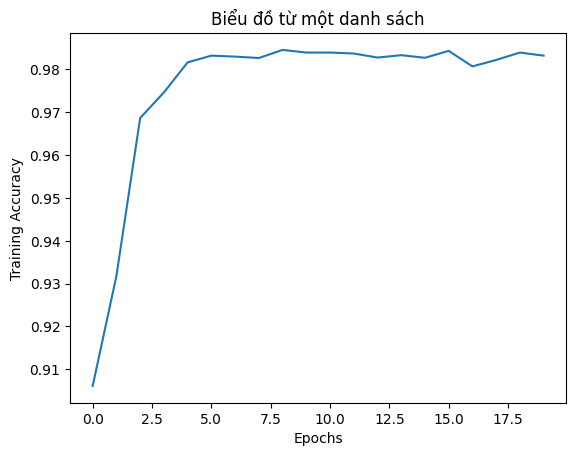

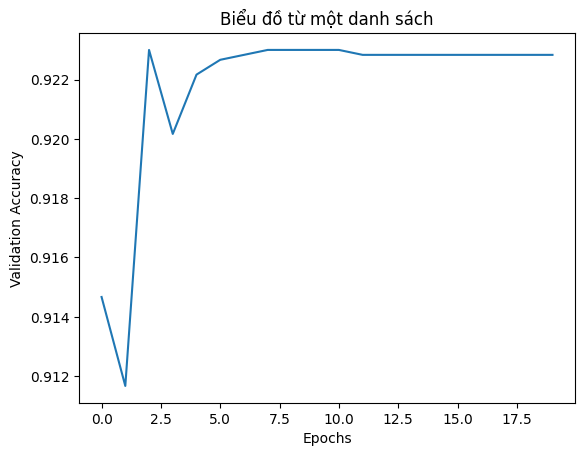

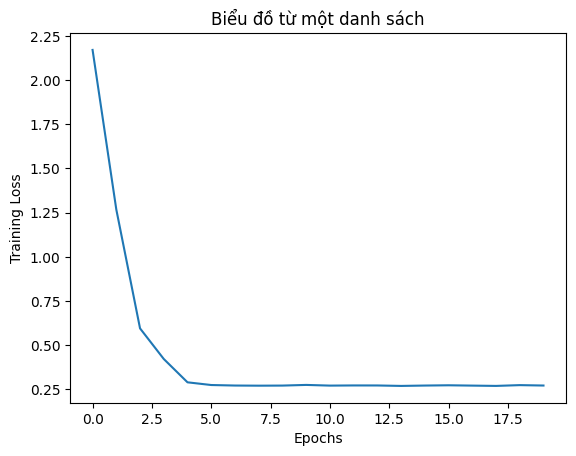

In [31]:
import matplotlib.pyplot as plt

plt.plot(total_train_acc)
plt.title('Biểu đồ từ một danh sách')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.show()

plt.plot(total_evaluate_acc)
plt.title('Biểu đồ từ một danh sách')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.show()

plt.plot(train_losses)
plt.title('Biểu đồ từ một danh sách')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.show()

In [32]:
print(min(train_losses))

0.2687915545438265


## Evaluate the model with test dataset

In [33]:
print("Checking the results of test dataset.")
model = model.to('cpu')
accu_test, _ = evaluate(test_dataloader)
print("test accuracy {:8.3f}".format(accu_test))

Checking the results of test dataset.


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument indices in method wrapper_CUDA___embedding_bag)

## Test on Random news

In [34]:
ag_news_label = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tec"}

def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item() + 1

ex_text_str = "I want to play badminton"
model = model.to("cpu")
print("This is a %s news" % ag_news_label[predict(ex_text_str, text_pipeline)])

This is a Sports news


#### Save and Load Model 

#### Plot 


In [20]:
import matplotlib.pyplot as plt
def plot(data_2d : torch.tensor):
   # %matplotlib mt
    data_2d = data_2d.numpy()
    
    if data_2d.ndim == 3  :
      data_2d = data_2d[0]
    elif data_2d.ndim == 1 :
      data_2d = data_2d[0]

    plt.figure(figsize=(10, 6))
    plt.imshow(data_2d, cmap='viridis', aspect='auto')
    plt.colorbar()
    plt.title('Heatmap of the Tensor Data')
    plt.xlabel('Columns')
    plt.ylabel('Rows')
    plt.show()

In [21]:
import torch 
max_len = 207
embed_dim = 512
 
pe = torch.zeros(max_len, embed_dim)
print(pe.shape)
position = torch.arange(0, max_len, dtype=torch.float16).unsqueeze(1)                                                                                                                                                                                   
div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-torch.log(torch.tensor(10000.0)) / embed_dim))
print(pe[:, 0::2].shape)
pe[:, 0::2] = torch.sin(position * div_term)
pe[:, 1::2] = torch.cos(position * div_term)
pe = pe.unsqueeze(0).transpose(0, 1)
print(pe[1].shape)
print(pe)

torch.Size([207, 512])
torch.Size([207, 256])
torch.Size([1, 512])
tensor([[[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
           0.0000e+00,  1.0000e+00]],

        [[ 8.4147e-01,  5.4030e-01,  8.2186e-01,  ...,  1.0000e+00,
           1.0366e-04,  1.0000e+00]],

        [[ 9.0930e-01, -4.1615e-01,  9.3641e-01,  ...,  1.0000e+00,
           2.0733e-04,  1.0000e+00]],

        ...,

        [[ 2.0212e-01, -9.7936e-01,  9.0414e-01,  ...,  9.9976e-01,
           2.1146e-02,  9.9978e-01]],

        [[-7.1490e-01, -6.9923e-01,  1.6396e-01,  ...,  9.9976e-01,
           2.1249e-02,  9.9977e-01]],

        [[-9.7464e-01,  2.2377e-01, -7.1732e-01,  ...,  9.9975e-01,
           2.1353e-02,  9.9977e-01]]])


torch.Size([207, 512])


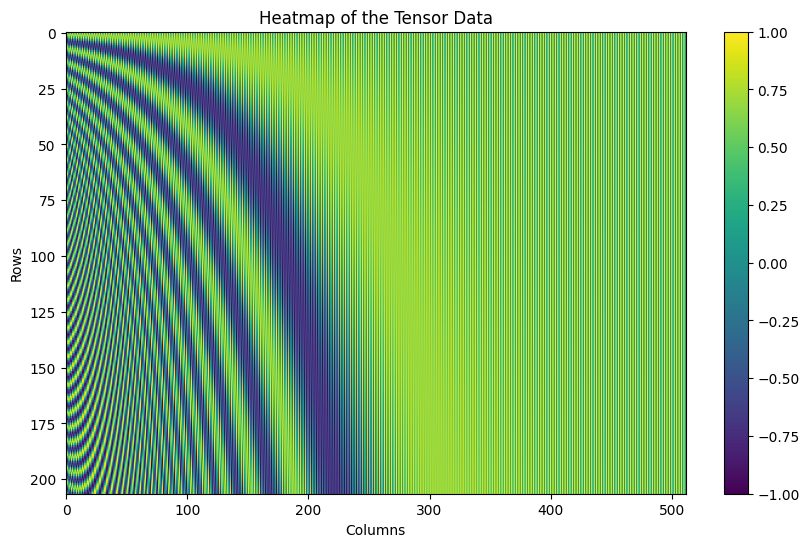

In [22]:
print(pe.squeeze(1).shape)
plot(pe.squeeze(1))

In [23]:
print(position.shape)
print(position)

torch.Size([207, 1])
tensor([[  0.],
        [  1.],
        [  2.],
        [  3.],
        [  4.],
        [  5.],
        [  6.],
        [  7.],
        [  8.],
        [  9.],
        [ 10.],
        [ 11.],
        [ 12.],
        [ 13.],
        [ 14.],
        [ 15.],
        [ 16.],
        [ 17.],
        [ 18.],
        [ 19.],
        [ 20.],
        [ 21.],
        [ 22.],
        [ 23.],
        [ 24.],
        [ 25.],
        [ 26.],
        [ 27.],
        [ 28.],
        [ 29.],
        [ 30.],
        [ 31.],
        [ 32.],
        [ 33.],
        [ 34.],
        [ 35.],
        [ 36.],
        [ 37.],
        [ 38.],
        [ 39.],
        [ 40.],
        [ 41.],
        [ 42.],
        [ 43.],
        [ 44.],
        [ 45.],
        [ 46.],
        [ 47.],
        [ 48.],
        [ 49.],
        [ 50.],
        [ 51.],
        [ 52.],
        [ 53.],
        [ 54.],
        [ 55.],
        [ 56.],
        [ 57.],
        [ 58.],
        [ 59.],
        [ 60.],
   

In [24]:
print(div_term.shape)
print(div_term)

torch.Size([256])
tensor([1.0000e+00, 9.6466e-01, 9.3057e-01, 8.9769e-01, 8.6596e-01, 8.3536e-01,
        8.0584e-01, 7.7737e-01, 7.4989e-01, 7.2339e-01, 6.9783e-01, 6.7317e-01,
        6.4938e-01, 6.2643e-01, 6.0430e-01, 5.8294e-01, 5.6234e-01, 5.4247e-01,
        5.2330e-01, 5.0481e-01, 4.8697e-01, 4.6976e-01, 4.5316e-01, 4.3714e-01,
        4.2170e-01, 4.0679e-01, 3.9242e-01, 3.7855e-01, 3.6517e-01, 3.5227e-01,
        3.3982e-01, 3.2781e-01, 3.1623e-01, 3.0505e-01, 2.9427e-01, 2.8387e-01,
        2.7384e-01, 2.6416e-01, 2.5483e-01, 2.4582e-01, 2.3714e-01, 2.2876e-01,
        2.2067e-01, 2.1288e-01, 2.0535e-01, 1.9810e-01, 1.9110e-01, 1.8434e-01,
        1.7783e-01, 1.7154e-01, 1.6548e-01, 1.5963e-01, 1.5399e-01, 1.4855e-01,
        1.4330e-01, 1.3824e-01, 1.3335e-01, 1.2864e-01, 1.2409e-01, 1.1971e-01,
        1.1548e-01, 1.1140e-01, 1.0746e-01, 1.0366e-01, 1.0000e-01, 9.6466e-02,
        9.3057e-02, 8.9769e-02, 8.6596e-02, 8.3536e-02, 8.0584e-02, 7.7736e-02,
        7.4989e-02, 7.

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0000e+00, 9.6466e-01, 9.3057e-01,  ..., 1.1140e-04, 1.0746e-04,
         1.0366e-04],
        [2.0000e+00, 1.9293e+00, 1.8611e+00,  ..., 2.2279e-04, 2.1492e-04,
         2.0733e-04],
        ...,
        [2.0400e+02, 1.9679e+02, 1.8984e+02,  ..., 2.2725e-02, 2.1922e-02,
         2.1147e-02],
        [2.0500e+02, 1.9776e+02, 1.9077e+02,  ..., 2.2836e-02, 2.2029e-02,
         2.1251e-02],
        [2.0600e+02, 1.9872e+02, 1.9170e+02,  ..., 2.2948e-02, 2.2137e-02,
         2.1355e-02]])


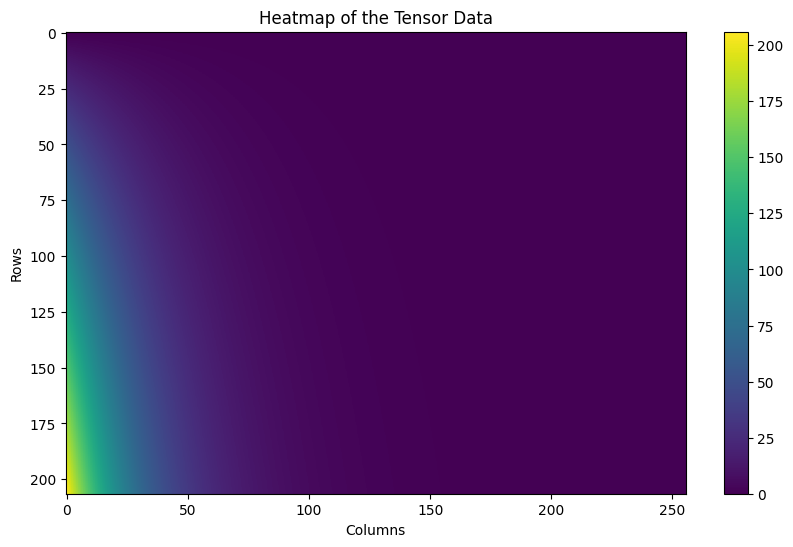

In [25]:
print(position * div_term)
plot(position * div_term)

In [26]:
input = torch.randn(1,max_len,embed_dim) # Create value in range[0:1]
print(input.shape)
print(input)

torch.Size([1, 207, 512])
tensor([[[ 4.7459e-01,  1.0149e+00, -1.6899e+00,  ..., -2.7072e-02,
           3.4330e-01,  1.3309e+00],
         [ 7.2934e-01,  6.8342e-01,  6.9593e-01,  ...,  5.9429e-01,
           2.2331e-01,  3.2258e-01],
         [-4.8979e-01, -1.2982e+00, -9.0087e-01,  ..., -8.6671e-01,
          -1.8740e-01,  3.3483e-01],
         ...,
         [ 2.7836e-01,  1.7692e+00,  6.2930e-02,  ..., -1.7195e-01,
          -8.2669e-02,  1.6193e+00],
         [ 6.8170e-02, -1.2880e-01,  2.8305e+00,  ..., -1.0751e+00,
           4.5670e-01,  1.3470e+00],
         [ 2.3068e-03,  6.5722e-01,  6.4028e-01,  ..., -4.5586e-01,
           1.1228e+00,  1.6913e-01]]])


In [27]:
print(pe[:input.size(1), :])
print(input)
print(input.size(1))
print(input+ pe[:input.size(1), :])

tensor([[[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
           0.0000e+00,  1.0000e+00]],

        [[ 8.4147e-01,  5.4030e-01,  8.2186e-01,  ...,  1.0000e+00,
           1.0366e-04,  1.0000e+00]],

        [[ 9.0930e-01, -4.1615e-01,  9.3641e-01,  ...,  1.0000e+00,
           2.0733e-04,  1.0000e+00]],

        ...,

        [[ 2.0212e-01, -9.7936e-01,  9.0414e-01,  ...,  9.9976e-01,
           2.1146e-02,  9.9978e-01]],

        [[-7.1490e-01, -6.9923e-01,  1.6396e-01,  ...,  9.9976e-01,
           2.1249e-02,  9.9977e-01]],

        [[-9.7464e-01,  2.2377e-01, -7.1732e-01,  ...,  9.9975e-01,
           2.1353e-02,  9.9977e-01]]])
tensor([[[ 4.7459e-01,  1.0149e+00, -1.6899e+00,  ..., -2.7072e-02,
           3.4330e-01,  1.3309e+00],
         [ 7.2934e-01,  6.8342e-01,  6.9593e-01,  ...,  5.9429e-01,
           2.2331e-01,  3.2258e-01],
         [-4.8979e-01, -1.2982e+00, -9.0087e-01,  ..., -8.6671e-01,
          -1.8740e-01,  3.3483e-01],
         ...,
         [ 2.78

torch.Size([1, 207, 512])
tensor([[[ 4.7459e-01,  2.0149e+00, -1.6899e+00,  ...,  9.7293e-01,
           3.4330e-01,  2.3309e+00],
         [ 7.2934e-01,  1.6834e+00,  6.9593e-01,  ...,  1.5943e+00,
           2.2331e-01,  1.3226e+00],
         [-4.8979e-01, -2.9825e-01, -9.0087e-01,  ...,  1.3329e-01,
          -1.8740e-01,  1.3348e+00],
         ...,
         [ 2.7836e-01,  2.7692e+00,  6.2930e-02,  ...,  8.2805e-01,
          -8.2669e-02,  2.6193e+00],
         [ 6.8170e-02,  8.7120e-01,  2.8305e+00,  ..., -7.5061e-02,
           4.5670e-01,  2.3470e+00],
         [ 2.3068e-03,  1.6572e+00,  6.4028e-01,  ...,  5.4414e-01,
           1.1228e+00,  1.1691e+00]]])


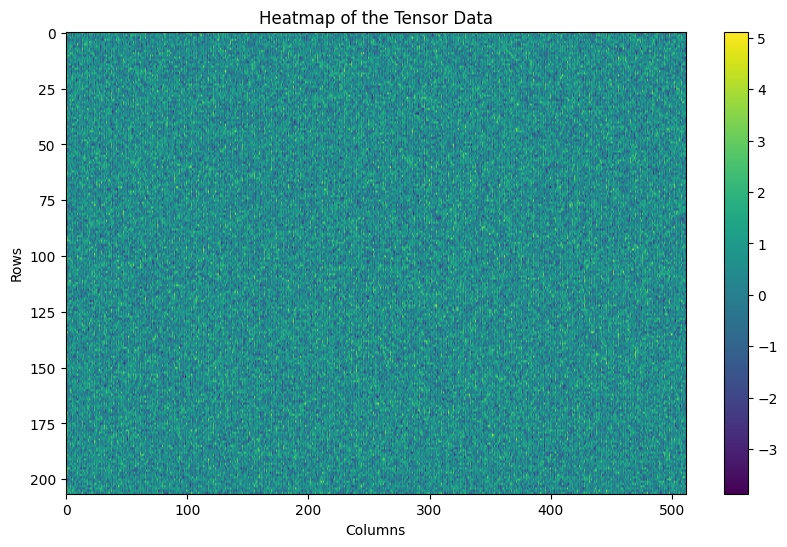

In [28]:
x = input + pe[:input.size(0), :]

print(x.shape)
print(x)
plot(x.squeeze(1))

In [29]:
import torch
import time

# Khởi tạo tensor
tensor = torch.randn(10000, 10000)

# Chuyển tensor sang GPU (CUDA)
tensor = tensor.to('cuda')
tensor

tensor([[ 0.0993,  2.1002,  1.7277,  ..., -0.7174,  0.1370,  1.6670],
        [ 0.0408, -0.2498, -0.1209,  ...,  1.1966, -0.3761,  0.5133],
        [ 0.0095, -0.2765, -0.7789,  ...,  0.3953, -0.5719, -0.7728],
        ...,
        [-0.5682, -0.2808,  0.4729,  ..., -0.7560, -0.3231, -0.2999],
        [ 0.5893, -0.2860, -1.0910,  ..., -0.3069, -1.2321,  0.8006],
        [-0.0479,  2.1175, -1.4430,  ...,  0.1364, -0.6578, -0.1831]],
       device='cuda:0')

In [30]:
t0 = time.time()
argmax_result = torch.argmax(tensor, dim=0)
print(time.time() - t0)
print(argmax_result)

0.0
tensor([9519, 9222, 1587,  ..., 7829, 6259, 8297], device='cuda:0')
